# **CNN & VGG-based Human Action Recognition Project**

# **download** **packages**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install plotly

# **Import** **the** **libraries**


In [3]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# **read the data**

In [2]:
dataset_path = '/content/drive/My Drive/Human Action Recognition'

## **prepare train test splits**

In [3]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Paths to your data and CSV files
dataset_path = '/content/drive/My Drive/HAR/Human Action Recognition'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')
train_labels_path = os.path.join(dataset_path, 'Training_set.csv')
test_labels_path = os.path.join(dataset_path, 'Testing_set.csv')  # Assuming you have a separate CSV for test labels

# Load the labels from the CSV files into DataFrames
train_labels_df = pd.read_csv(train_labels_path)
test_labels_df = pd.read_csv(test_labels_path)  # If you have test labels

# Split the data into training and validation sets
train_df, valid_df = train_test_split(train_labels_df, test_size=0.3, random_state=42, stratify=train_labels_df['label'])

# **Preparing the data**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerators with normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Generators for training and validation data using the dataframes
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col='filename',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_path,
    x_col='filename',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

# ImageDataGenerator for test data, rescaling only
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator for test data using the dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels_df,  # Dataframe containing test filenames only
    directory=test_path,
    x_col='filename',
    target_size=(64, 64),
    batch_size=32,
    class_mode=None,  # Since we don't have labels
    shuffle=False  # Keep data in same order as dataframe for evaluation
)

Found 8820 validated image filenames belonging to 15 classes.
Found 3780 validated image filenames belonging to 15 classes.
Found 5400 validated image filenames.


# **Data Visualization**

In [4]:
# View the first few rows of the training dataframe
print(train_df.head())

              filename     label
652      Image_653.jpg   dancing
11396  Image_11397.jpg  drinking
11773  Image_11774.jpg  clapping
7259    Image_7260.jpg    eating
4818    Image_4819.jpg   sitting


In [5]:
# View the first few rows of the validation dataframe
print(valid_df.head())

            filename               label
963    Image_964.jpg  listening_to_music
1733  Image_1734.jpg  listening_to_music
4676  Image_4677.jpg            clapping
9816  Image_9817.jpg             hugging
2706  Image_2707.jpg             running


In [6]:
# View the first few rows of the test dataframe
print(test_labels_df.head())

      filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg


In [7]:
print(train_df.describe())

             filename    label
count            8820     8820
unique           8820       15
top     Image_653.jpg  dancing
freq                1      588


In [8]:
print(valid_df.describe())

             filename               label
count            3780                3780
unique           3780                  15
top     Image_964.jpg  listening_to_music
freq                1                 252


In [9]:
print(test_labels_df.describe())

           filename
count          5400
unique         5400
top     Image_1.jpg
freq              1


In [19]:
# Check that you have more than one instance per class
print(train_labels_df['label'].value_counts())

# Verify the distribution of the splits
print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(valid_df)} samples")
print(f"Test set: {len(test_labels_df)} samples")

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64
Train set: 8820 samples
Validation set: 3780 samples
Test set: 5400 samples


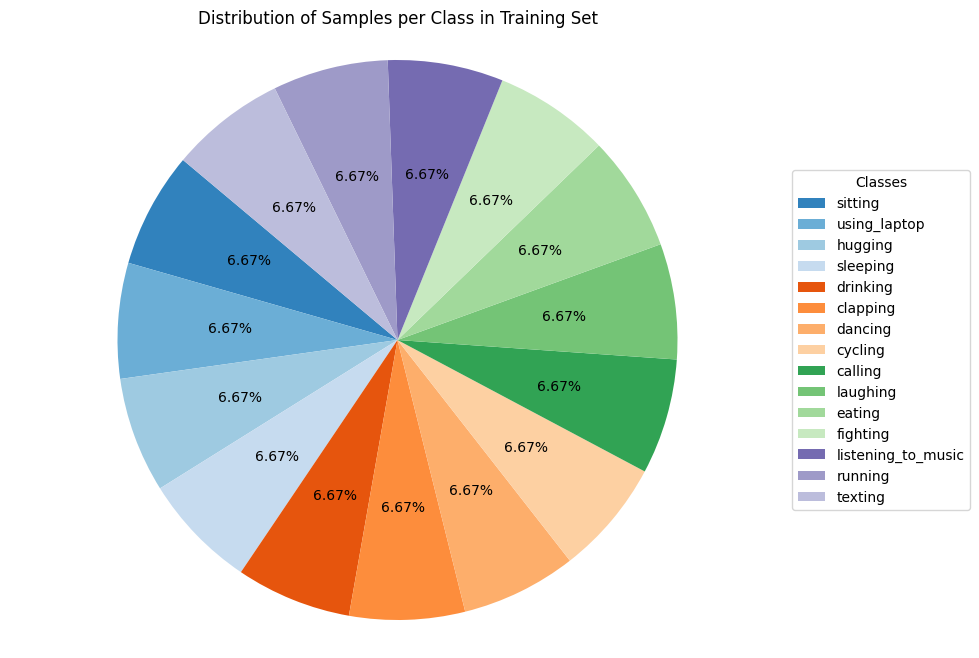

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_labels_df is already defined and has a 'label' column

# Get the counts of each label
label_counts = train_labels_df['label'].value_counts()

# Create a DataFrame from the label counts
df = pd.DataFrame({'label': label_counts.index, 'samples': label_counts.values})

# Plotting the pie chart
plt.figure(figsize=(10, 8))
colors = plt.cm.tab20c.colors  # Using tab20c colormap for more distinct colors if needed
wedges, texts, autotexts = plt.pie(df['samples'], colors=colors, startangle=140, autopct='%1.2f%%')

# Adding a legend
plt.legend(wedges, df['label'], title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Adding a title
plt.title('Distribution of Samples per Class in Training Set')

# Display the plot
plt.show()

# **Prepare model**

## **CNN Model**

In [ ]:
import tensorflow as tf

# Number of unique classes in your dataset
num_unique_classes = 15  # Assuming 15 different classes

# Instantiate a Sequential model
cnn = tf.keras.models.Sequential()

# Add a Convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[128, 128, 3]))

# Add a Pooling layer
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Add a second Convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))

# Add a second Pooling layer
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Add a Flattening layer
cnn.add(tf.keras.layers.Flatten())

# Add a Fully-connected layer
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Add an Output layer
cnn.add(tf.keras.layers.Dense(units=num_unique_classes, activation='softmax'))

# Print the model summary
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 128)               3

In [ ]:
# Compile the model with Adam optimizer and categorical crossentropy loss
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = cnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25  # Adjust the number of epochs as needed
)

Epoch 1/25
275/275 [==============================] - 2905s 11s/step - loss: 2.6855 - accuracy: 0.1041 - val_loss: 2.5984 - val_accuracy: 0.1433
Epoch 2/25
275/275 [==============================] - 256s 929ms/step - loss: 2.5351 - accuracy: 0.1705 - val_loss: 2.4167 - val_accuracy: 0.2209
Epoch 3/25
275/275 [==============================] - 268s 975ms/step - loss: 2.4289 - accuracy: 0.2121 - val_loss: 2.3998 - val_accuracy: 0.2558
Epoch 4/25
275/275 [==============================] - 270s 979ms/step - loss: 2.3373 - accuracy: 0.2417 - val_loss: 2.2950 - val_accuracy: 0.2609
Epoch 5/25
275/275 [==============================] - 269s 980ms/step - loss: 2.2649 - accuracy: 0.2656 - val_loss: 2.3326 - val_accuracy: 0.2664
Epoch 6/25
275/275 [==============================] - 265s 965ms/step - loss: 2.2362 - accuracy: 0.2705 - val_loss: 2.2462 - val_accuracy: 0.2842
Epoch 7/25
275/275 [==============================] - 269s 975ms/step - loss: 2.2063 - accuracy: 0.2893 - val_loss: 2.7076 - 

As seen above after 25 epochs the accuracy is low so we employ early stopping

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Increase the model complexity
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[128, 128, 3]),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    # Additional layers
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=num_unique_classes, activation='softmax')
])

# Compile the model with a different optimizer and/or learning rate
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Fit the model with the new settings
history = cnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25,  # Adjust the number of epochs as needed
    callbacks=[early_stopping]
)

Epoch 1/25
275/275 [==============================] - 627s 2s/step - loss: 2.6237 - accuracy: 0.1140 - val_loss: 2.5971 - val_accuracy: 0.1520
Epoch 2/25
275/275 [==============================] - 618s 2s/step - loss: 2.4469 - accuracy: 0.1952 - val_loss: 2.4204 - val_accuracy: 0.2195
Epoch 3/25
275/275 [==============================] - 603s 2s/step - loss: 2.3750 - accuracy: 0.2214 - val_loss: 2.4070 - val_accuracy: 0.2203
Epoch 4/25
275/275 [==============================] - 622s 2s/step - loss: 2.3340 - accuracy: 0.2311 - val_loss: 2.3699 - val_accuracy: 0.2272
Epoch 5/25
275/275 [==============================] - 621s 2s/step - loss: 2.2933 - accuracy: 0.2473 - val_loss: 2.2555 - val_accuracy: 0.2773
Epoch 6/25
275/275 [==============================] - 600s 2s/step - loss: 2.2593 - accuracy: 0.2634 - val_loss: 2.5048 - val_accuracy: 0.2225
Epoch 7/25
275/275 [==============================] - 619s 2s/step - loss: 2.2339 - accuracy: 0.2711 - val_loss: 2.2973 - val_accuracy: 0.2704

## **After using early stopping the accuracy reduced so we do transfer learning with VGG MODEL**